# Use small set of data

For experimenting in local computer with limited resource

In [1]:
import math
import pandas as pd
import cv2
import numpy as np
from glob import glob
from concurrent.futures import ProcessPoolExecutor
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50, VGG16, Xception
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import Callback, LearningRateScheduler
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


## Get top labels
get labels with more data in it.

In [2]:
num_classes = 120
df = pd.read_csv('data2/labels.csv')

# get top 10 breed
breed = df.groupby(['breed'])['breed'].count().nlargest(num_classes)
breed = [i for i in breed.index]  # get index name only

# labels in breed
labels = df[df['breed'].isin(breed)]

## Preparing data and labels

In [3]:
ROWS = 300
COLS = 300
CHANNELS = 3
CORE = 4


def resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    with ProcessPoolExecutor(max_workers=CORE) as executor:
        data[:] = list(executor.map(resize_img, images))
    
    return data


lb = LabelBinarizer()

files = ['data2/train/%s.jpg' % i['id'] for _, i in labels.iterrows()]
text_labels = [i['breed'] for _, i in labels.iterrows()]

x = prep_data(files)
y = lb.fit_transform(text_labels)

## Split dataset for train and test

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
del x  # clear memory

## Feature extraction

In [5]:
inc = ResNet50(include_top=False, weights='imagenet')

features_train = inc.predict(x_train, verbose=1)
features_valid = inc.predict(x_valid, verbose=1)

# clear unused variable
del x_train
del x_valid

2045/2045 [==============================] - 37s 18ms/step


## Model

In [23]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

lr = 0.01
# sgd = SGD(lr=lr, momentum=0.9, decay=1e-6, nesterov=True)
sgd = SGD(lr=lr)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['categorical_accuracy'])

## Train network

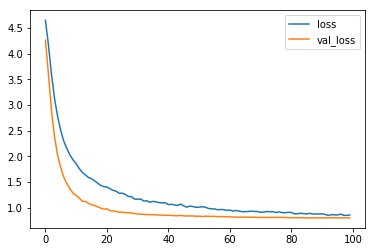

8177/8177 [==============================] - 1s 142us/step - loss: 0.8540 - categorical_accuracy: 0.7406 - val_loss: 0.7994 - val_categorical_accuracy: 0.7614


In [24]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        
def lr_schedule(epoch):
    return lr * math.pow(0.5, math.floor((1 + epoch)/30.0))

        
plot_losses = PlotLosses()
model.fit(
    features_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(features_valid, y_valid),
    verbose=1,
    callbacks=[plot_losses, LearningRateScheduler(lr_schedule)]
)

In [25]:
model.evaluate(features_valid, y_valid)

2045/2045 [==============================] - 0s 54us/step


[0.7994143029296894, 0.7613691933289134]

## Predict on test data

In [26]:
x_test = prep_data(glob('data2/test/*'))

In [27]:
features_test = inc.predict(x_test, verbose=1)
del x_test

10357/10357 [==============================] - 187s 18ms/step


In [28]:
predict = model.predict(features_test, verbose=1)

10357/10357 [==============================] - 1s 56us/step


In [29]:
data = {}
filenames = [i.split(".")[0].replace("data2/test/", "") for i in glob('data2/test/*')]

for k in range(num_classes):
    key = lb.classes_[k]
    data[key] = predict[:, k]


dt = pd.DataFrame(data)
dt.insert(0, "id", filenames)
dt.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,a111748da0baecb190cac84b46f1129c,2.459922e-11,1.814696e-04,5.509759e-10,1.776340e-07,4.390779e-13,4.339392e-10,8.162089e-09,5.979250e-13,2.597838e-08,...,4.913257e-02,1.035042e-09,5.601761e-09,3.858404e-09,7.931788e-09,1.429996e-05,4.675053e-11,1.055829e-10,5.957329e-08,1.556973e-08
1,27165f9104e2fcb67cb54917aa88f096,1.111712e-07,2.436980e-07,4.453962e-06,8.992841e-06,1.459067e-05,5.023727e-04,5.374828e-05,1.445135e-02,3.595754e-04,...,6.725371e-06,2.948589e-04,1.132602e-08,1.557802e-04,3.237952e-07,6.107351e-04,8.137739e-06,3.978368e-05,1.408842e-03,7.847189e-06
2,ed48b89faa9069c700db2448696a97af,1.243140e-09,1.558936e-10,1.273096e-08,1.807007e-08,8.992746e-03,1.031799e-06,1.635280e-07,9.090468e-01,4.714495e-06,...,4.968753e-09,1.482748e-04,5.998429e-05,2.250887e-03,1.503044e-06,1.732075e-06,1.090675e-08,2.857159e-02,4.189901e-06,2.115602e-07
3,8ab2c099a5ffb7e5b9781c4e4317a4fe,1.577436e-07,1.579331e-06,4.954005e-08,3.682045e-06,2.481312e-02,2.687929e-06,3.651538e-08,2.473903e-05,3.503302e-05,...,4.149360e-08,7.823286e-06,6.777230e-05,4.401625e-05,1.515541e-02,1.897471e-07,2.787025e-07,1.436888e-02,3.434538e-06,2.200031e-07
4,0aee2e38a7ac39c80dbf0dbc81e830a5,9.941702e-01,4.088648e-10,4.192565e-11,2.430431e-11,1.399220e-09,4.722261e-10,8.385550e-07,1.412112e-11,6.711623e-10,...,6.980162e-08,1.870225e-09,1.303854e-11,1.350356e-11,3.924361e-12,3.781120e-11,2.037200e-06,1.222094e-09,1.112776e-08,6.671850e-05


In [30]:
dt.to_csv('predictions.csv', index=False)